
# DL HW3, Q3: **Semi-Supervised Learning on Fashion MNIST**

This notebook implements **semi-supervised learning** following the **M1 scheme** from the paper *"Semi-Supervised Learning with Deep Generative Models"* by Kingma et al. The approach consists of two steps:

1. **Variational Autoencoder (VAE)** – to extract latent representations of Fashion MNIST images.
2. **Support Vector Machine (SVM)** – to classify the images based on their VAE-generated features.

We evaluate the performance of this approach using different numbers of labeled samples (**100, 600, 1000, and 3000**), as presented in Table 1 of the paper. Unlike the original method, we use a **standard SVM with a kernel of choice** and do not apply self-training.

---

## Setup

In [3]:
import torch
from torch.optim import Adam
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import joblib

from models.VAE import VAE, loss_function
from data.fashion_mnist import get_fashion_mnist_datasets
from tqdm import tqdm
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

%load_ext autoreload
%autoreload 2


Using device: cpu


## Define Hyperparameters



In [4]:
# Hyperparameters
NUM_LABELS_LIST = [100, 600, 1000, 3000]
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 1e-3
SVM_KERNEL = 'rbf'
# VAE architecture parameters (set to those like M1)
HIDDEN_DIM = 500
Z_DIM = 50


## Define Functions


In [5]:
from tqdm import tqdm

# Function to train VAE
def train_vae(model, labeled_loader, optimizer, epochs=10):
    model.train()
    for epoch in tqdm(range(1, epochs + 1), desc="Epochs"):
        train_loss = 0
        # Training on labeled data
        for batch_idx, (data, _) in enumerate(tqdm(labeled_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        # print(f'====> Epoch: {epoch} Average loss: {train_loss / len(labeled_loader.dataset):.4f}')


In [6]:
# Function to extract features using the encoder part of VAE
def extract_features(model, data_loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            features.append(mu.cpu().numpy())
            labels.append(target.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

def evaluate_model(model, clf, data_loader):
    model.eval()
    features, labels = extract_features(model, data_loader)
    pred = clf.predict(features)
    accuracy = accuracy_score(labels, pred)
    return accuracy

In [7]:
# Plot histograms to ensure the data is balanced
def plot_histogram(labeled_loader, unlabeled_loader):
    # Extract labels from the labeled loader
    labeled_labels = []
    for _, labels in labeled_loader:
        labeled_labels.extend(labels.numpy())

    # Extract labels from the unlabeled loader
    unlabeled_labels = []
    for _, labels in unlabeled_loader:
        unlabeled_labels.extend(labels.numpy())

    # Plot histograms
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(labeled_labels, bins=np.arange(11)-0.5, rwidth=0.8, color='blue', edgecolor='black')
    plt.title(f'Labeled Data Distribution (Count: {len(labeled_labels)})')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.xticks(range(10))  # Ensure that the bins are recognizable

    plt.subplot(1, 2, 2)
    plt.hist(unlabeled_labels, bins=np.arange(11)-0.5, rwidth=0.8, color='green', edgecolor='black')
    plt.title(f'Unlabeled Data Distribution (Count: {len(unlabeled_labels)})')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.xticks(range(10))  # Ensure that the bins are recognizable
    
    plt.tight_layout()
    plt.show()


# Plot some random samples from the dataset
def plot_random_samples(dataset, num_samples=10):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    samples = [dataset[idx][0].numpy().squeeze() for idx in indices]
    labels = [dataset[idx][1] for idx in indices]
    
    plt.figure(figsize=(15, 3))
    for i, sample in enumerate(samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(sample, cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()


In [8]:
# Function to train and evaluate the SVM
def train_svm(unlabeled_features, unlabeled_labels):
    # Train SVM classifier using unlabeled data features
    clf = svm.SVC(kernel=SVM_KERNEL)
    clf.fit(unlabeled_features, unlabeled_labels)
    return clf


In [9]:
# Function to run the entire experiment and evaluate results
def train_m1(num_labels):
    labeled_loader, unlabeled_loader, test_loader = get_fashion_mnist_datasets(num_labels)

    # Plot histograms of labeled and unlabeled data
    plot_histogram(labeled_loader, unlabeled_loader)
    
    # Plot some random samples from the dataset
    # plot_random_samples(labeled_loader.dataset.dataset)

    model = VAE(hidden_dim=HIDDEN_DIM, latent_dim=Z_DIM).to(device)
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    # Train VAE
    train_vae(model, labeled_loader, optimizer, epochs=EPOCHS)

    # Extract features for classifier training
    unlabeled_features, unlabeled_labels = extract_features(model, unlabeled_loader)

    # Train and evaluate SVM
    clf = train_svm(unlabeled_features, unlabeled_labels)
    accuracy = evaluate_model(model, clf, test_loader)
    

    # Get the current directory of the Jupyter notebook
    notebook_dir = os.getcwd()

    # Define the correct paths dynamically
    models_dir = os.path.join(notebook_dir, "models")

    # Save the models
    torch.save(model.state_dict(), os.path.join(models_dir, f'vae_model_{num_labels}.pth'))
    joblib.dump(clf, os.path.join(models_dir, f'svm_model_{num_labels}.joblib'))

    return accuracy


## Training



Running experiment with 100 labels...


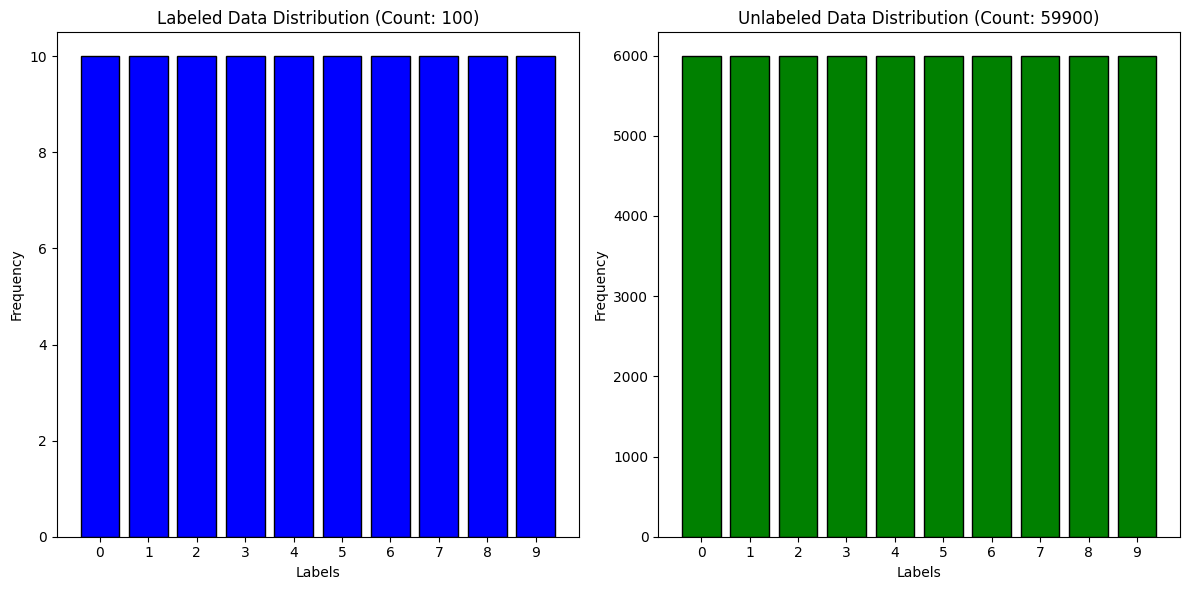

Epochs: 100%|██████████| 100/100 [00:00<00:00, 125.48it/s]


Accuracy with 100 labels: 0.8021

Running experiment with 600 labels...


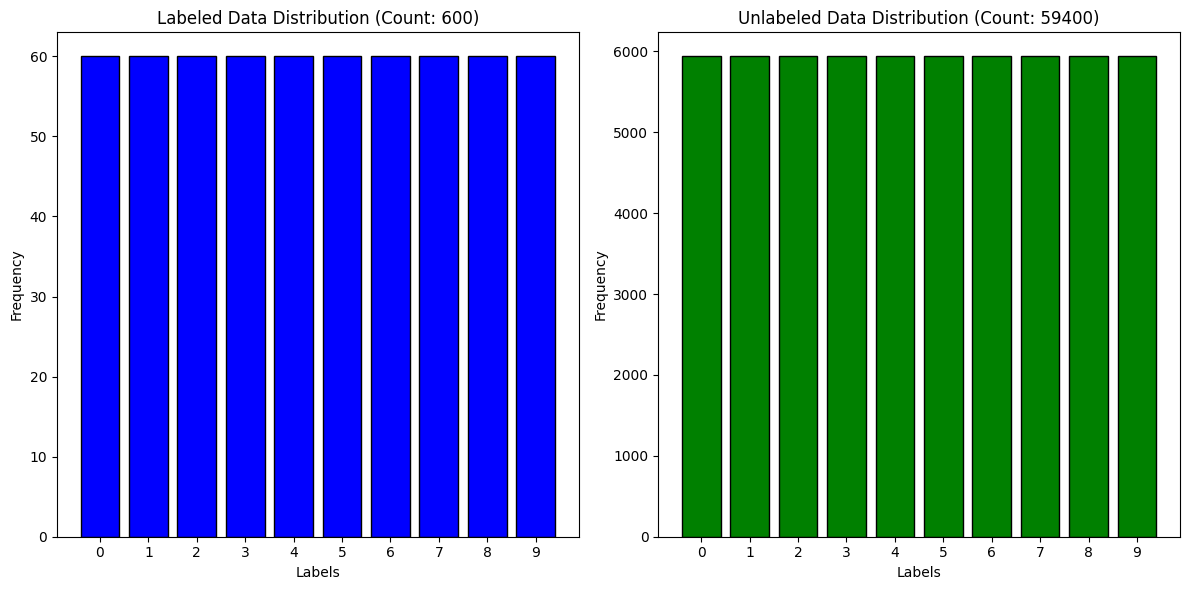

Epochs: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Accuracy with 600 labels: 0.8409

Running experiment with 1000 labels...


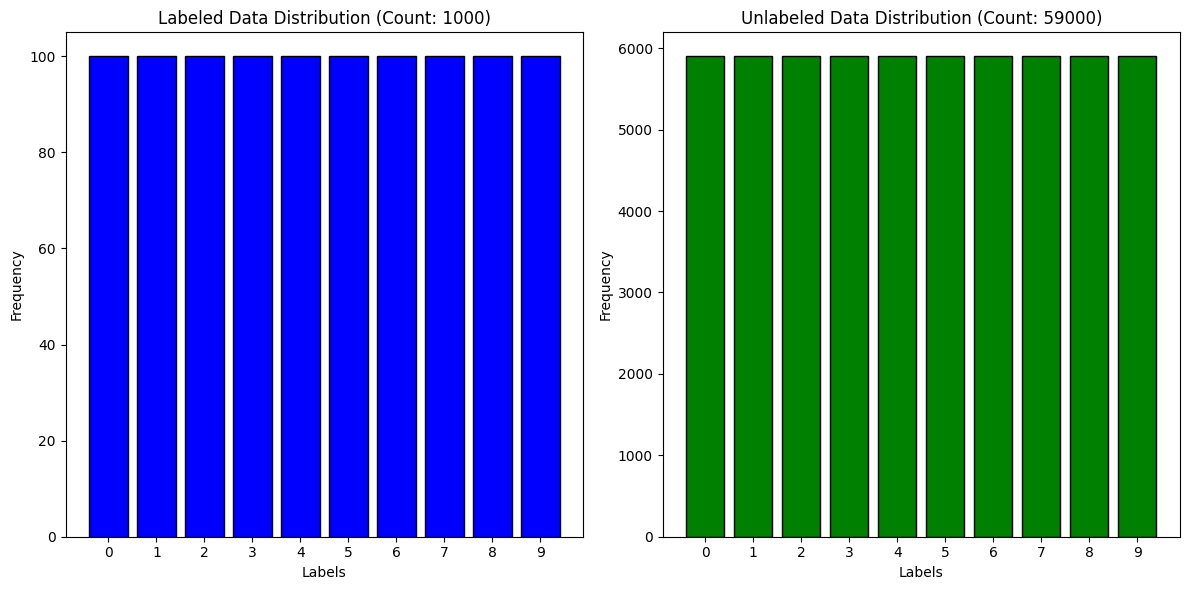

Epochs: 100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


Accuracy with 1000 labels: 0.8489

Running experiment with 3000 labels...


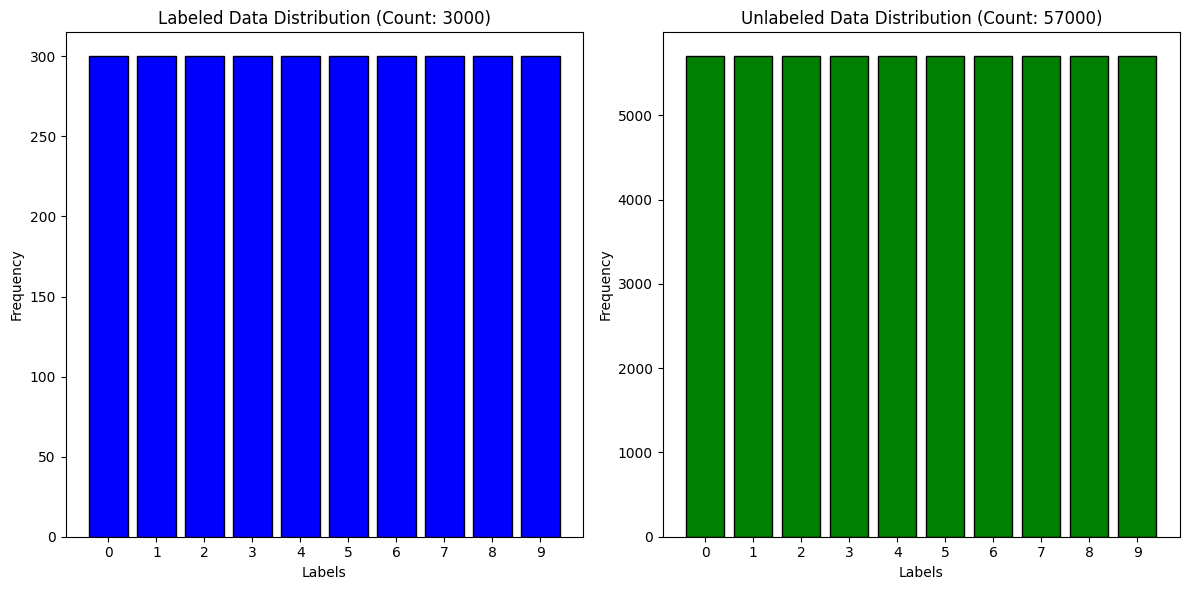

Epochs: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Accuracy with 3000 labels: 0.8637


In [10]:
# Run the experiment for different numbers of labels
for num_labels in NUM_LABELS_LIST:
    print(f"\nRunning experiment with {num_labels} labels...")
    accuracy = train_m1(num_labels)
    print(f'Accuracy with {num_labels} labels: {accuracy:.4f}')


## Evaluation


In [13]:
from data.fashion_mnist import FAHSION_MNIST_CLASSES
# Function to load models and evaluate
def load_and_evaluate_model(num_labels):

    # Ensure the correct directory is referenced
    models_dir = os.path.join(os.getcwd(), "models")

    # Construct correct paths
    vae_model_path = os.path.join(models_dir, f"vae_model_{num_labels}.pth")
    svm_model_path = os.path.join(models_dir, f"svm_model_{num_labels}.joblib")

    # Check if files exist before loading
    if not os.path.exists(vae_model_path):
        raise FileNotFoundError(f"Model file not found: {vae_model_path}")

    if not os.path.exists(svm_model_path):
        raise FileNotFoundError(f"SVM file not found: {svm_model_path}")

    # Load the models correctly
    model = VAE().to(device)
    model.load_state_dict(torch.load(vae_model_path))

    clf = joblib.load(svm_model_path)
    # model = VAE().to(device)
    # model.load_state_dict(torch.load(fr'..\models\vae_model_{num_labels}.pth'))
    # clf = joblib.load(fr'..\models\svm_model_{num_labels}.joblib')
    
    _, _, test_loader = get_fashion_mnist_datasets(num_labels)
    accuracy = evaluate_model(model, clf, test_loader)
    
    print(f'Accuracy with {num_labels} labels (loaded model): {accuracy:.4f}')
    
    # Visualize some generated samples
    visualize_generated_samples(model, clf, num_labels)
    
    return accuracy

def visualize_generated_samples(model, clf, num_labels, num_samples=10):
    """Generate and save sample images with predictions inside 'figures' folder."""
    
    # Create the 'figures' directory inside the project folder if it doesn't exist
    figures_dir = os.path.join(os.getcwd(), "figures")
    os.makedirs(figures_dir, exist_ok=True)

    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
        generated = model.decode(z).view(-1, 1, 28, 28)
        features, _ = model.encode(generated.view(-1, 784))
        pred = clf.predict(features)

        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        for i in range(num_samples):
            axes[i].imshow(generated[i].cpu().numpy().squeeze(), cmap='gray')
            axes[i].set_title(f'Pred: {FAHSION_MNIST_CLASSES[pred[i]]}', fontsize=8)
            axes[i].axis('off')
        plt.suptitle(f'Generated Samples for {num_labels} Labels')

        # Save the image inside the 'figures' folder
        image_path = os.path.join(figures_dir, f"{num_labels}_labels.png")
        plt.savefig(image_path)
        plt.close()

    print(f"Saved generated samples to {image_path}")

In [16]:
# import pandas as pd 

# Initialize list to store results
results = []

# Load and evaluate saved models
for num_labels in NUM_LABELS_LIST:
    print(f"\nEvaluating saved model with {num_labels} labels...")
    accuracy = load_and_evaluate_model(num_labels)
    results.append({'Number of Labels': num_labels, 'Accuracy': accuracy})

# Create DataFrame and display table
# results_df = pd.DataFrame(results)
# print(results_df)


results




Evaluating saved model with 100 labels...


/var/folders/vg/4l1g62w15cbf7_36gvpjs8w40000gn/T/ipykernel_17547/483116250.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(vae_model_pa

Accuracy with 100 labels (loaded model): 0.8021
Saved generated samples to /Users/devleibowitz/Documents/TAU Courses/Deep Learning Raja/HW/dl_homeworks/HW3/figures/100_labels.png

Evaluating saved model with 600 labels...


/var/folders/vg/4l1g62w15cbf7_36gvpjs8w40000gn/T/ipykernel_17547/483116250.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(vae_model_pa

Accuracy with 600 labels (loaded model): 0.8409
Saved generated samples to /Users/devleibowitz/Documents/TAU Courses/Deep Learning Raja/HW/dl_homeworks/HW3/figures/600_labels.png

Evaluating saved model with 1000 labels...


/var/folders/vg/4l1g62w15cbf7_36gvpjs8w40000gn/T/ipykernel_17547/483116250.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(vae_model_pa

Accuracy with 1000 labels (loaded model): 0.8489
Saved generated samples to /Users/devleibowitz/Documents/TAU Courses/Deep Learning Raja/HW/dl_homeworks/HW3/figures/1000_labels.png

Evaluating saved model with 3000 labels...


/var/folders/vg/4l1g62w15cbf7_36gvpjs8w40000gn/T/ipykernel_17547/483116250.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(vae_model_pa

Accuracy with 3000 labels (loaded model): 0.8637
Saved generated samples to /Users/devleibowitz/Documents/TAU Courses/Deep Learning Raja/HW/dl_homeworks/HW3/figures/3000_labels.png


[{'Number of Labels': 100, 'Accuracy': 0.8021},
 {'Number of Labels': 600, 'Accuracy': 0.8409},
 {'Number of Labels': 1000, 'Accuracy': 0.8489},
 {'Number of Labels': 3000, 'Accuracy': 0.8637}]